In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
X, y = make_classification(n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.850 (0.128)


Ideal: 0.840
> folds=2, accuracy=0.740 (0.700,0.780)
> folds=3, accuracy=0.749 (0.697,0.824)
> folds=4, accuracy=0.790 (0.640,0.920)
> folds=5, accuracy=0.810 (0.600,0.950)
> folds=6, accuracy=0.820 (0.688,0.941)
> folds=7, accuracy=0.799 (0.571,1.000)
> folds=8, accuracy=0.811 (0.385,0.923)
> folds=9, accuracy=0.829 (0.636,1.000)
> folds=10, accuracy=0.850 (0.600,1.000)
> folds=11, accuracy=0.829 (0.667,1.000)
> folds=12, accuracy=0.785 (0.250,1.000)
> folds=13, accuracy=0.839 (0.571,1.000)
> folds=14, accuracy=0.807 (0.429,1.000)
> folds=15, accuracy=0.821 (0.571,1.000)
> folds=16, accuracy=0.827 (0.500,1.000)
> folds=17, accuracy=0.816 (0.600,1.000)
> folds=18, accuracy=0.831 (0.600,1.000)
> folds=19, accuracy=0.826 (0.600,1.000)
> folds=20, accuracy=0.830 (0.600,1.000)
> folds=21, accuracy=0.814 (0.500,1.000)
> folds=22, accuracy=0.820 (0.500,1.000)
> folds=23, accuracy=0.802 (0.250,1.000)
> folds=24, accuracy=0.804 (0.250,1.000)
> folds=25, accuracy=0.810 (0.250,1.000)
> folds=26,

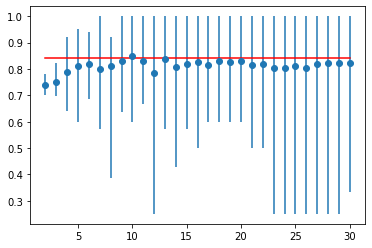

In [6]:
# sensitivity analysis of k in k-fold cross-validation
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# create the dataset
def get_dataset(n_samples=100):
	X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y
 
# retrieve the model to be evaluate
def get_model():
	model = LogisticRegression()
	return model
 
# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = get_dataset()
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()
 
# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()

A line plot is created comparing the mean accuracy scores to the LOOCV result with the min and max of each result distribution indicated using error bars.

The results suggest that for this model on this dataset, most k values underestimate the performance of the model compared to the ideal case. The results suggest that perhaps k=10 alone is slightly optimistic and perhaps k=13 might be a more accurate estimate.



# Correlation of Test Harness With Target
Once a test harness is chosen, another consideration is how well it matches the ideal test condition across different algorithms.

It is possible that for some algorithms and some configurations, the k-fold cross-validation will be a better approximation of the ideal test condition compared to other algorithms and algorithm configurations.

We can evaluate and report on this relationship explicitly. This can be achieved by calculating how well the k-fold cross-validation results across a range of algorithms match the evaluation of the same algorithms on the ideal test condition.

The Pearson’s correlation coefficient can be calculated between the two groups of scores to measure how closely they match. That is, do they change together in the same ways: when one algorithm looks better than another via k-fold cross-validation, does this hold on the ideal test condition?

We expect to see a strong positive correlation between the scores, such as 0.5 or higher. A low correlation suggests the need to change the k-fold cross-validation test harness to better match the ideal test condition.

1. First, we can define a function that will create a list of standard machine learning models to evaluate via each test harness.

In [7]:
# get a list of models to evaluate
def get_models():
	models = list()
	models.append(LogisticRegression())
	models.append(RidgeClassifier())
	models.append(SGDClassifier())
	models.append(PassiveAggressiveClassifier())
	models.append(KNeighborsClassifier())
	models.append(DecisionTreeClassifier())
	models.append(ExtraTreeClassifier())
	models.append(LinearSVC())
	models.append(SVC())
	models.append(GaussianNB())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier())
	models.append(RandomForestClassifier())
	models.append(ExtraTreesClassifier())
	models.append(GaussianProcessClassifier())
	models.append(GradientBoostingClassifier())
	models.append(LinearDiscriminantAnalysis())
	models.append(QuadraticDiscriminantAnalysis())
	return models

In [13]:
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [14]:
# evaluate the model using a given test condition
def evaluate_model(cv, model):
	# get the dataset
	X, y = get_dataset()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores)

In [15]:
# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
	# evaluate model using each test condition
	cv_mean = evaluate_model(cv, model)
	ideal_mean = evaluate_model(ideal_cv, model)
	# check for invalid results
	if isnan(cv_mean) or isnan(ideal_mean):
		continue
	# store results
	cv_results.append(cv_mean)
	ideal_results.append(ideal_mean)
	# summarize progress
	print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))


>LogisticRegression: ideal=0.840, cv=0.850
>RidgeClassifier: ideal=0.830, cv=0.830
>SGDClassifier: ideal=0.700, cv=0.760
>PassiveAggressiveClassifier: ideal=0.750, cv=0.770
>KNeighborsClassifier: ideal=0.760, cv=0.770
>DecisionTreeClassifier: ideal=0.730, cv=0.630
>ExtraTreeClassifier: ideal=0.620, cv=0.670
>LinearSVC: ideal=0.830, cv=0.840
>SVC: ideal=0.900, cv=0.880
>GaussianNB: ideal=0.730, cv=0.720
>AdaBoostClassifier: ideal=0.740, cv=0.740
>BaggingClassifier: ideal=0.780, cv=0.790
>RandomForestClassifier: ideal=0.790, cv=0.770
>ExtraTreesClassifier: ideal=0.810, cv=0.840
>GaussianProcessClassifier: ideal=0.790, cv=0.760
>GradientBoostingClassifier: ideal=0.820, cv=0.810
>LinearDiscriminantAnalysis: ideal=0.830, cv=0.830
>QuadraticDiscriminantAnalysis: ideal=0.650, cv=0.710


In [16]:
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)

Correlation: 0.856


We can see that for some algorithms, the test harness over-estimates the accuracy compared to LOOCV, and in other cases, it under-estimates the accuracy. This is to be expected.

At the end of the run, we can see that the correlation between the two sets of results is reported. In this case, we can see that a correlation of 0.746 is reported, which is a good strong positive correlation. The results suggest that 10-fold cross-validation does provide a good approximation for the LOOCV test harness on this dataset as calculated with 18 popular machine learning algorithms.

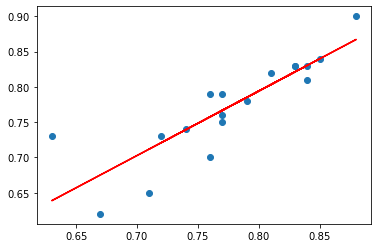

In [17]:
# scatter plot of results
pyplot.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
pyplot.plot(cv_results, line, color='r')
# show the plot
pyplot.show()

a scatter plot is created comparing the distribution of mean accuracy scores for the test harness (x-axis) vs. the accuracy scores via LOOCV (y-axis).

A red line of best fit is drawn through the results showing the strong linear correlation.



This provides a harness for comparing your chosen test harness to an ideal test condition on your own dataset.